# Adversarial Images Overview

In this notebook, we will explore crafting adversarial images and how to make more robust models that are harder to confuse. This is a toy example comprising a simple convolutional neural network which we train ourselves using the CIFAR-10 dataset, one of the less resource-intensive image datasets. Everyone should be able to run this notebook on CPU or on a free Colab T4 GPU.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

Using device: cpu


Here's our simple CNN:

In [2]:
class SimpleNet(nn.Module):
    """Simple CNN for CIFAR-10 classification"""
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Data Preparation

The normalisation here is more extensive than in previous notebooks. This process standardises the pixel values of the images based on the mean values for color channels in the CIFAR-10 dataset. See the comments in the code to explain 

As in previous notebooks, we get the data from TorchVision and use the DataLoader. 


In [3]:
# Data preparation
print("Loading CIFAR-10 dataset...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), # the mean values for red, green, blue channels
                         (0.2023, 0.1994, 0.2010)) # standard deviation values for red, green, blue channels
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Dataset loaded: {len(trainset)} training samples, {len(testset)} test samples")


Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Dataset loaded: 50000 training samples, 10000 test samples



📊 Sample training data:


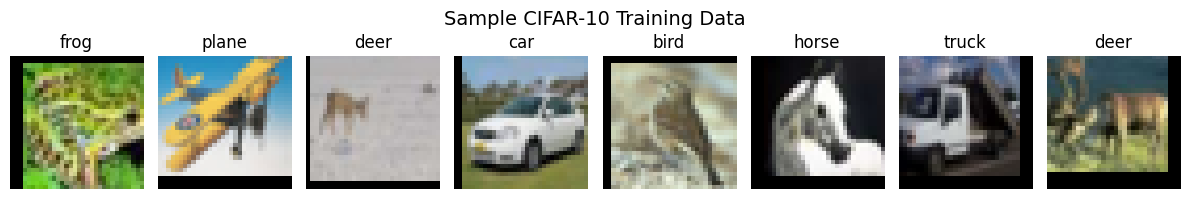

In [4]:
# Visualize some training data
def show_sample_data(dataloader, num_samples=8):
    """Show sample images from the dataset"""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Denormalize for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    images_viz = images * std + mean
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    fig.suptitle('Sample CIFAR-10 Training Data', fontsize=14)
    
    for i in range(num_samples):
        axes[i].imshow(images_viz[i].permute(1, 2, 0).clamp(0, 1))
        axes[i].set_title(f'{classes[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n📊 Sample training data:")
show_sample_data(trainloader)

In [5]:
def train_model(model, trainloader, epochs=10, lr=0.001, model_name="Model"):
    """Train the model and show progress"""
    print(f"\nTraining {model_name}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    train_accuracies = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/len(trainloader):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
    
    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(range(1, epochs+1), train_losses, 'b-', linewidth=2)
    ax1.set_title(f'{model_name} Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(range(1, epochs+1), train_accuracies, 'g-', linewidth=2)
    ax2.set_title(f'{model_name} Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ {model_name} training complete! Final accuracy: {epoch_acc:.2f}%")
    return model

In [6]:
def test_model(model, testloader):
    """Test model accuracy and show results"""
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    accuracy = 100 * correct / total
    
    # Show per-class accuracy
    print(f"\n📊 Test Results:")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print("\nPer-class Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f"  {classes[i]:>8}: {class_acc:.1f}%")
    
    return accuracy



🎓 Training our baseline (clean) model...

Training Clean Model...


Epoch 8/8: 100%|██████| 391/391 [00:12<00:00, 32.38it/s, Loss=0.760, Acc=73.58%]


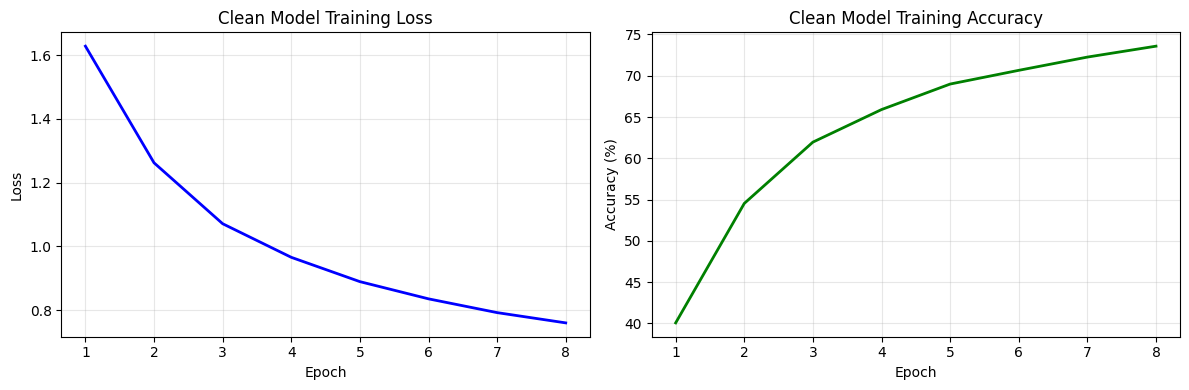

✅ Clean Model training complete! Final accuracy: 73.58%

Testing clean model performance:

📊 Test Results:
Overall Accuracy: 76.80%

Per-class Accuracy:
     plane: 79.4%
       car: 86.9%
      bird: 63.9%
       cat: 55.6%
      deer: 73.4%
       dog: 61.4%
      frog: 83.8%
     horse: 85.4%
      ship: 88.8%
     truck: 89.4%


In [7]:
# Train the clean model
print("\nTraining our baseline (clean) model...")
clean_model = SimpleNet()
clean_model = train_model(clean_model, trainloader, epochs=8, model_name="Clean Model")

print("\nTesting clean model performance:")
clean_accuracy = test_model(clean_model, testloader)

### Adversarial attacks

Let's start with some clean examples:


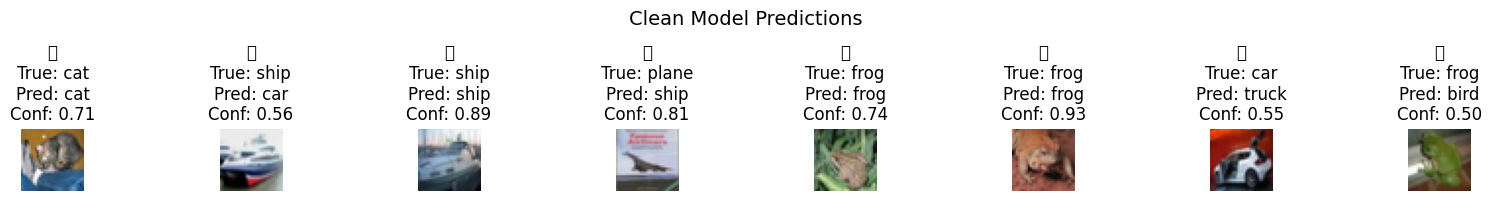

Clean accuracy on sample: 50.0%


In [8]:
# Utility functions
def denormalize_images(images):
    """Denormalise CIFAR-10 images for visualization"""
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(images.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(images.device)
    return images * std + mean

# Get sample data for demonstrations
dataiter = iter(testloader)
sample_images, sample_labels = next(dataiter)
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

print("Let's start with some clean examples:")

# Show clean predictions
def show_clean_predictions(model, images, labels, num_examples=8):
    """Show clean model predictions"""
    model.eval()
    with torch.no_grad():
        outputs = model(images[:num_examples])
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        confidences = torch.max(probs, dim=1)[0]
    
    images_viz = denormalize_images(images[:num_examples])
    
    fig, axes = plt.subplots(1, num_examples, figsize=(16, 2))
    fig.suptitle('Clean Model Predictions', fontsize=14)
    
    for i in range(num_examples):
        axes[i].imshow(images_viz[i].permute(1, 2, 0).clamp(0, 1))
        correct = '✅' if preds[i] == labels[i] else '❌'
        axes[i].set_title(f'{correct}\nTrue: {classes[labels[i]]}\nPred: {classes[preds[i]]}\nConf: {confidences[i]:.2f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    accuracy = (preds == labels[:num_examples]).sum().item() / num_examples
    print(f"Clean accuracy on sample: {accuracy*100:.1f}%")

show_clean_predictions(clean_model, sample_images, sample_labels)

### FGSM

The Fast Gradient Sign Attack is one of the key adversarial attacks to cause untargeted or targeted misclassifications.

Rather than minimizing the loss by adjusting the weights based on backpropagated gradients, the FGSM seeks to adjust the input data to maximize the loss based on the same backpropagated gradients. [This](https://docs.pytorch.org/tutorials/beginner/fgsm_tutorial.html) PyTorch tutorial provides a good introduction to the algorithm. 

Here is the 

### 
Core FGSM Formula

$$xadv=x+ϵ⋅sign(∇xJ(θ,x,y))$$

x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))xadv​=x+ϵ⋅sign(∇x​J(θ,x,y))$$

Where:

$x$ = original input (clean example)

$x_{adv}$ = adversarial example

$ϵ$ = (epsilon) perturbation magnitude (attack strength)

$J(θ,x,y)$ = loss function with parameters 
$θ$, input $x$, and true label $y$

$∇xJ(θ,x,y)$ = gradient of loss with respect to input $x$

$\text{sign}(\cdot)$ sign function (returns -1, 0, or +1)

This means we take the original input $x$, compute the gradient of the loss function with respect to that input $∇xJ(θ,x,y)$, take the sign of that gradient, multiply by the perturbation magnitude $ϵ$ ('epsilon'), and add this to the original input to create the adversarial example.

In [9]:
def fgsm_attack(model, images, labels, epsilon):
    """
    Fast Gradient Sign Method (FGSM) Attack
    
    This function creates adversarial examples by adding small perturbations
    to input images in the direction that maximizes the model's loss.
    
    Args:
        model: The neural network model to attack
        images: Input images tensor (batch_size, channels, height, width)
        labels: True labels for the images
        epsilon: Maximum perturbation magnitude (controls attack strength)
    """
    # Prepare the images for computing gradients
    # We need to clone the images to avoid manipulating the 
    # original data. We detatch from any existing computational
    # graph, then re-enable gradient tracking.
    images = images.clone().detach().requires_grad_(True)

    # Forward pass through the model: get the predictions
    # for the original images
    outputs = model(images)

    # Calculate the loss using cross entropy
    loss = F.cross_entropy(outputs, labels)

    # Prepare for the backward pass by clearing
    # any existing gradients in model parameters
    model.zero_grad()

    # Clear any existing gradients on the input images
    # This means we start with a clean slate for gradient computation
    if images.grad is not None:
        images.grad.zero_()

    # Backward pass: calculate gradients of the loss with respect to the input
    # image. This tells us how to change each pixel to increase the loss
    loss.backward()

    # Verify gradients were computed
    if images.grad is None:
        print("Warning: No gradients computed. Returning original images.")
        return images.detach()

    # Extract and use gradients of the loss with respect to input pixels
    # to craft adversarial pertubations
    data_grad = images.grad

    # Create adversarial examples using the FGSM: 
    # x_adversarial = x_original + epsilon * sign(gradient)
    # sign gives the direction that increases loss
    perturbed_data = images + epsilon * data_grad.sign()

    # We have to clamp values to keep them within the expected 
    # normalized input range
    perturbed_data = torch.clamp(perturbed_data, -2.5, 2.5)

    # Detach from computation graph since we have no need for 
    # gradients for the output
    return perturbed_data.detach()

In [10]:
def demonstrate_fgsm_attack(model, images, labels, epsilon, num_examples=6):
    """Demonstrate FGSM attack with visualization"""
    print(f"\nFGSM Attack Demonstration (ε = {epsilon})")
    
    # Generate adversarial examples
    adv_images = fgsm_attack(model, images, labels, epsilon)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        clean_outputs = model(images[:num_examples])
        adv_outputs = model(adv_images[:num_examples])
        
        clean_preds = torch.argmax(clean_outputs, dim=1)
        adv_preds = torch.argmax(adv_outputs, dim=1)
        
        clean_probs = F.softmax(clean_outputs, dim=1)
        adv_probs = F.softmax(adv_outputs, dim=1)
        
        clean_conf = torch.max(clean_probs, dim=1)[0]
        adv_conf = torch.max(adv_probs, dim=1)[0]
    
    # Visualize
    clean_viz = denormalize_images(images[:num_examples])
    adv_viz = denormalize_images(adv_images[:num_examples])
    perturbations = (adv_images[:num_examples] - images[:num_examples]) * 10 + 0.5
    
    fig, axes = plt.subplots(3, num_examples, figsize=(2*num_examples, 6))
    fig.suptitle(f'FGSM Attack Results (ε = {epsilon})', fontsize=16)
    
    successful_attacks = 0
    
    for i in range(num_examples):
        # Clean image
        axes[0, i].imshow(clean_viz[i].permute(1, 2, 0).clamp(0, 1))
        axes[0, i].set_title(f'Original\n{classes[labels[i]]}\nConf: {clean_conf[i]:.2f}', fontsize=9)
        axes[0, i].axis('off')
        
        # Perturbation (amplified)
        axes[1, i].imshow(perturbations[i].permute(1, 2, 0).clamp(0, 1))
        l2_norm = torch.norm(adv_images[i] - images[i]).item()
        axes[1, i].set_title(f'Perturbation ×10\nL2: {l2_norm:.3f}', fontsize=9)
        axes[1, i].axis('off')
        
        # Adversarial image
        axes[2, i].imshow(adv_viz[i].permute(1, 2, 0).clamp(0, 1))
        attack_success = adv_preds[i] != labels[i]
        if attack_success:
            successful_attacks += 1
        symbol = '🎯' if attack_success else '✅'
        color = 'red' if attack_success else 'green'
        axes[2, i].set_title(f'Adversarial {symbol}\n{classes[adv_preds[i]]}\nConf: {adv_conf[i]:.2f}', 
                           fontsize=9, color=color)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    success_rate = (successful_attacks / num_examples) * 100
    print(f"🎯 Attack Success Rate: {successful_attacks}/{num_examples} ({success_rate:.1f}%)")
    
    return successful_attacks



FGSM Attack Demonstration (ε = 0.01)


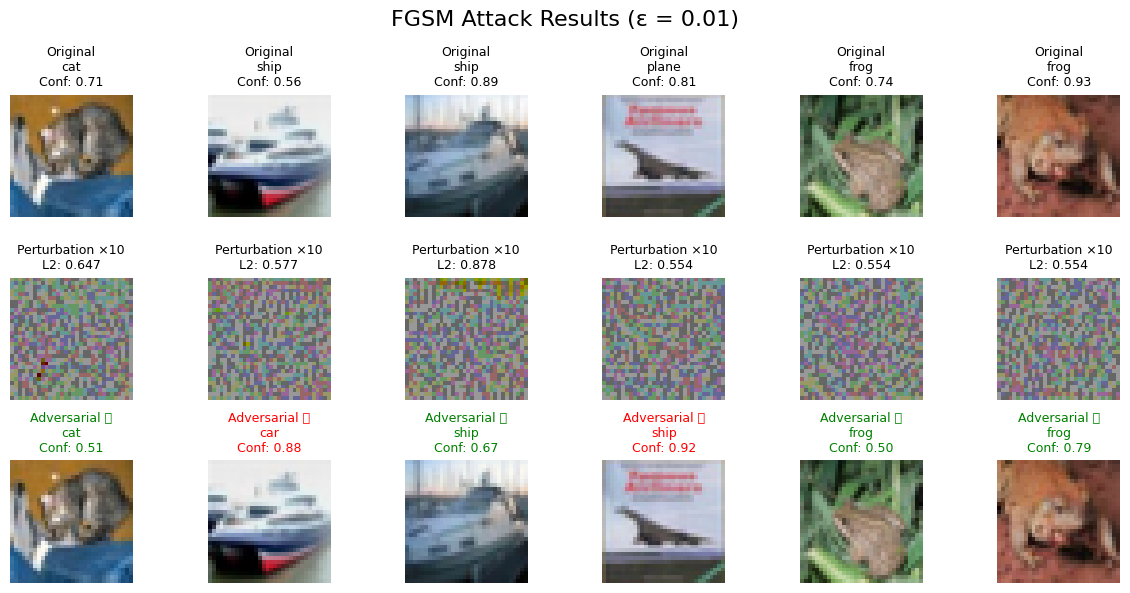

🎯 Attack Success Rate: 2/6 (33.3%)

FGSM Attack Demonstration (ε = 0.03)


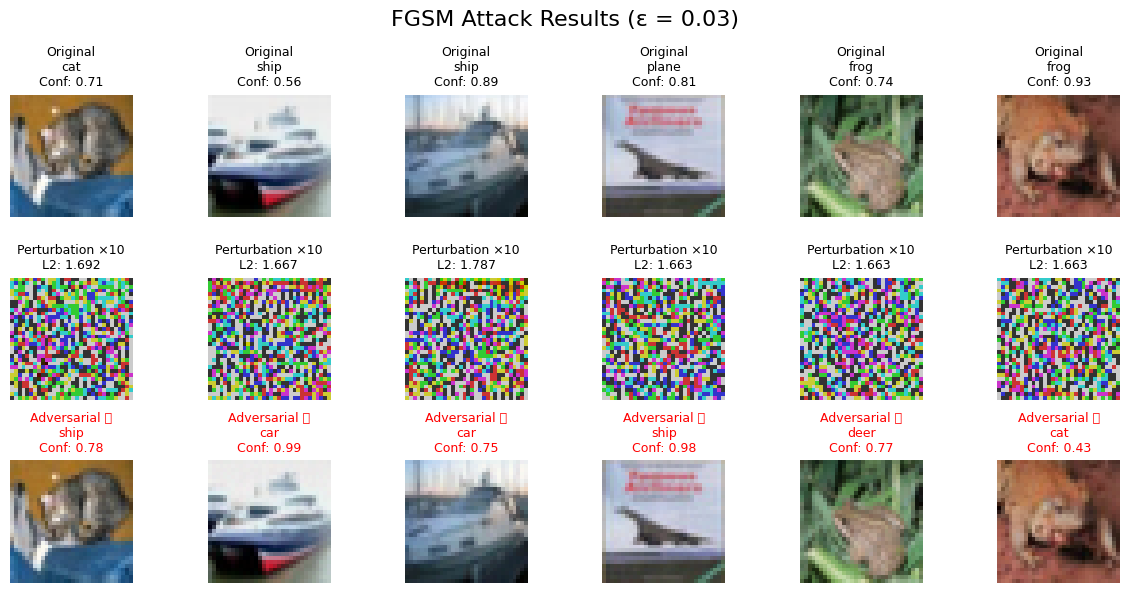

🎯 Attack Success Rate: 6/6 (100.0%)

FGSM Attack Demonstration (ε = 0.07)


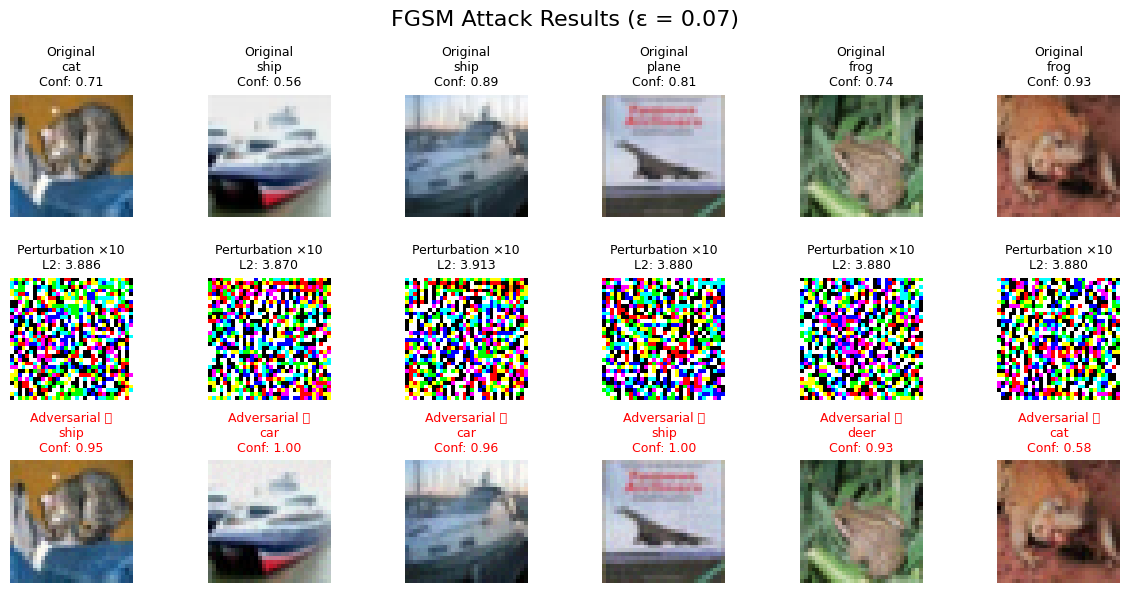

🎯 Attack Success Rate: 6/6 (100.0%)


In [11]:
# Demonstrate FGSM with different epsilon values
epsilons = [0.01, 0.03, 0.07]
for eps in epsilons:
    demonstrate_fgsm_attack(clean_model, sample_images, sample_labels, eps)

### Projected Gradient Descent (PGD) Attack

PGD is an iterative attack that refines adversarial examples over multiple steps.
It's more powerful than FGSM because it can find better adversarial examples
by taking multiple smaller steps and projecting back to the allowed perturbation region.

#### Core PGD Formula (Iterative)

$x(t+1)=Πx+S(x(t)+α⋅sign(∇xJ(θ,x(t),y)))$

Where:

$x^{(t)}$ = adversarial example at iteration $t$

$x^{(t+1)}$ = adversarial example at iteration $t+1$

$x(0)$ = $x+uniform(−ϵ,ϵ) = random initialization within ϵ-ball

$Πx+S$ = projection operator onto feasible set $S$

$S={x′:∣∣x′−x∣∣∞≤ϵ}$ = $L\infty$ ball of radius ϵ 

$α\alpha$ = step size (typically $α=ϵ/k\alpha$ where $k$
is number of iterations)

$J(θ,x,y)J(\theta, x, y)$ = loss function

$∇xJ(θ,x(t),y)$ = gradient of loss with respect to current adversarial example

PDG therefore applies multiple gradient steps vs PGD's single step. The projection operator $Πx+S$ ensures pertubations stay within the ϵ-ball, the allowed perturbation space, after each step.


In [12]:
def pgd_attack(model, images, labels, epsilon, alpha=0.01, num_iter=10):
    """
    Projected Gradient Descent (PGD) Attack
    Args:
    model: The neural network model to attack
    images: Input images tensor (batch_size, channels, height, width)
    labels: True labels for the images
    epsilon: Maximum allowed perturbation magnitude (L∞ constraint)
    alpha: Step size for each iteration (should be smaller than epsilon)
    num_iter: Number of attack iterations to perform

    """

    # Just as with FGSM, we clone the data
    images = images.clone().detach()
    
    # Unlike FGSM, where we start with clean images, PGD begins with random noise
    # uniform(-epsilon, epsilon) creates random values between -epsilon and epsilon
    perturbed_images = images + torch.empty_like(images).uniform_(-epsilon, epsilon)

    # Ensure initial perturbed images stay within valid pixel range
    perturbed_images = torch.clamp(perturbed_images, -2.5, 2.5)

    # Iterative refinement loop:
    # PGD takes multiple gradient steps to iteratively improve 
    # an adversarial example
    for i in range(num_iter):

        # Detach from previous iteration's computation graph, enable gradients
        perturbed_images = perturbed_images.detach().requires_grad_(True)

        # Forward pass 
        outputs = model(perturbed_images)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Clear gradients from model parameters and input images
        model.zero_grad()
        if perturbed_images.grad is not None:
            perturbed_images.grad.zero_()
        
        # Calculate how to change pixels to increase the loss
        loss.backward()

        # If no gradients computed, exit
        if perturbed_images.grad is None:
            break

        # Move in the direction that increases loss
        # alpha is the step size - smaller than epsilon for gradual improvement
        data_grad = perturbed_images.grad
        perturbed_images = perturbed_images + alpha * data_grad.sign()
        
        # Project back to epsilon ball - this is the 'projected' in PGD
        # Ensure pixels aren't perturbed by more than epsilon
        delta = perturbed_images - images

        # Constrain perturbation and ensure pixels within valid range
        delta = torch.clamp(delta, -epsilon, epsilon)
        perturbed_images = torch.clamp(images + delta, -2.5, 2.5)

    # Just as FGSM, we don't need gradients for output 
    # so we detach from compuation graph
    return perturbed_images.detach()


Attack Comparison (ε = 0.03)


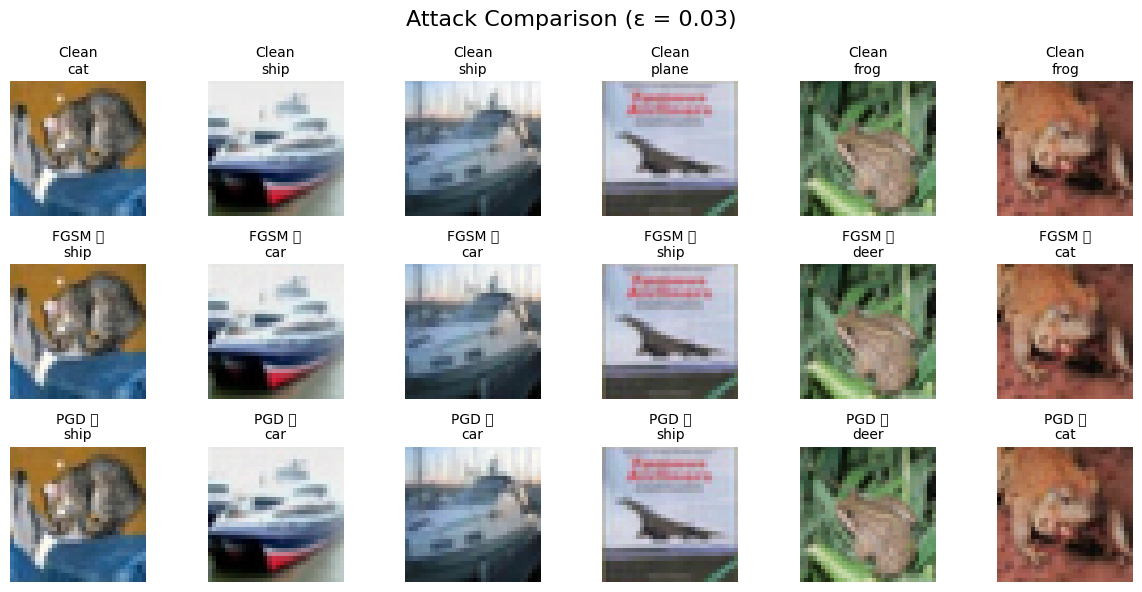

FGSM Success Rate: 6/6 (100.0%)
PGD Success Rate:  6/6 (100.0%)


In [13]:
def compare_attacks(model, images, labels, epsilon, num_examples=6):
    """Compare FGSM vs PGD attacks"""
    print(f"\nAttack Comparison (ε = {epsilon})")
    
    fgsm_adv = fgsm_attack(model, images, labels, epsilon)
    pgd_adv = pgd_attack(model, images, labels, epsilon)
    
    model.eval()
    with torch.no_grad():
        clean_outputs = model(images[:num_examples])
        fgsm_outputs = model(fgsm_adv[:num_examples])
        pgd_outputs = model(pgd_adv[:num_examples])
        
        clean_preds = torch.argmax(clean_outputs, dim=1)
        fgsm_preds = torch.argmax(fgsm_outputs, dim=1)
        pgd_preds = torch.argmax(pgd_outputs, dim=1)
    
    clean_viz = denormalize_images(images[:num_examples])
    fgsm_viz = denormalize_images(fgsm_adv[:num_examples])
    pgd_viz = denormalize_images(pgd_adv[:num_examples])
    
    fig, axes = plt.subplots(3, num_examples, figsize=(2*num_examples, 6))
    fig.suptitle(f'Attack Comparison (ε = {epsilon})', fontsize=16)
    
    fgsm_success = 0
    pgd_success = 0
    
    for i in range(num_examples):
        # Clean
        axes[0, i].imshow(clean_viz[i].permute(1, 2, 0).clamp(0, 1))
        axes[0, i].set_title(f'Clean\n{classes[labels[i]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # FGSM
        axes[1, i].imshow(fgsm_viz[i].permute(1, 2, 0).clamp(0, 1))
        fgsm_attack_success = fgsm_preds[i] != labels[i]
        if fgsm_attack_success:
            fgsm_success += 1
        symbol = '🎯' if fgsm_attack_success else '✅'
        axes[1, i].set_title(f'FGSM {symbol}\n{classes[fgsm_preds[i]]}', fontsize=10)
        axes[1, i].axis('off')
        
        # PGD
        axes[2, i].imshow(pgd_viz[i].permute(1, 2, 0).clamp(0, 1))
        pgd_attack_success = pgd_preds[i] != labels[i]
        if pgd_attack_success:
            pgd_success += 1
        symbol = '🎯' if pgd_attack_success else '✅'
        axes[2, i].set_title(f'PGD {symbol}\n{classes[pgd_preds[i]]}', fontsize=10)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"FGSM Success Rate: {fgsm_success}/{num_examples} ({100*fgsm_success/num_examples:.1f}%)")
    print(f"PGD Success Rate:  {pgd_success}/{num_examples} ({100*pgd_success/num_examples:.1f}%)")

compare_attacks(clean_model, sample_images, sample_labels, 0.03)

Testing robustness across epsilon values...
ε = 0.005: 69.60%
ε = 0.010: 64.80%
ε = 0.020: 53.40%
ε = 0.030: 43.00%
ε = 0.050: 28.00%
ε = 0.070: 18.60%
ε = 0.100: 9.00%


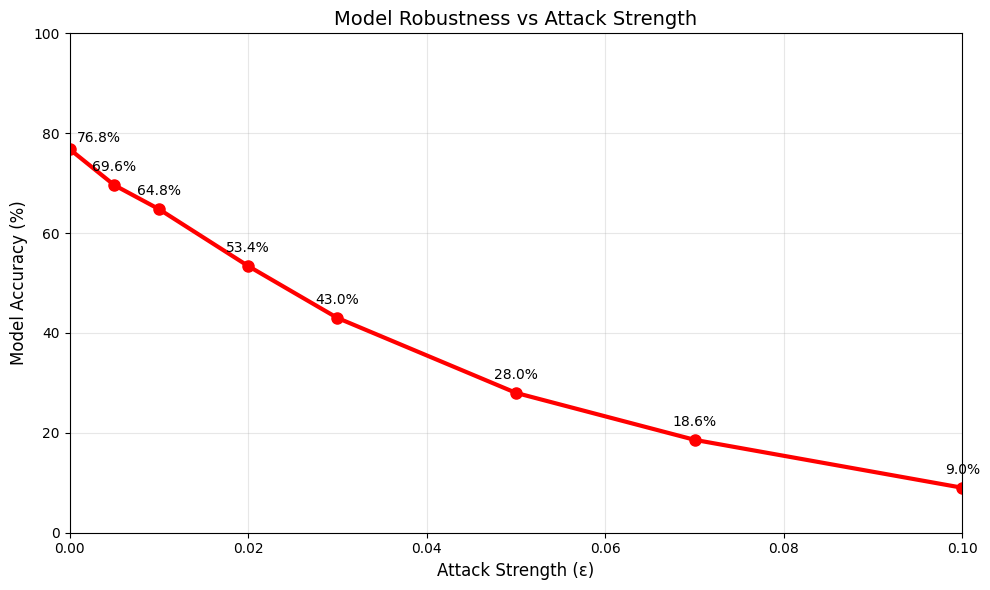


💡 Key Observations:
• Small perturbations (ε < 0.01) already reduce accuracy significantly
• The model becomes very vulnerable as ε increases
• This shows the fundamental vulnerability of standard neural networks


In [14]:
def plot_robustness_curve(model, testloader, attack_fn, epsilons, max_batches=5):
    """Plot model robustness vs epsilon"""
    accuracies = []
    
    print("Testing robustness across epsilon values...")
    for eps in epsilons:
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(testloader):
            if batch_idx >= max_batches:
                break
                
            inputs, labels = inputs.to(device), labels.to(device)
            adv_inputs = attack_fn(model, inputs, labels, eps)
            
            with torch.no_grad():
                outputs = model(adv_inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f"ε = {eps:.3f}: {accuracy:.2f}%")
    
    plt.figure(figsize=(10, 6))
    plt.plot([0] + epsilons, [clean_accuracy] + accuracies, 'ro-', linewidth=3, markersize=8)
    plt.xlabel('Attack Strength (ε)', fontsize=12)
    plt.ylabel('Model Accuracy (%)', fontsize=12)
    plt.title('Model Robustness vs Attack Strength', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max(epsilons))
    plt.ylim(0, 100)
    
    # Add annotations
    plt.annotate(f'{clean_accuracy:.1f}%', (0, clean_accuracy), 
                textcoords="offset points", xytext=(5,5), ha='left')
    for i, (eps, acc) in enumerate(zip(epsilons, accuracies)):
        plt.annotate(f'{acc:.1f}%', (eps, acc), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return accuracies

eps_range = [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1]
clean_robustness = plot_robustness_curve(clean_model, testloader, fgsm_attack, eps_range)

This graph shows small perturbations (ε < 0.01) already reduce accuracy significantly. The model also looks more vulnerable as ε increases.

### Defences

Adversarial training is a common precaution against perturbed samples. We add adversarial images to the training data in the hope that the model becomes harder to deceive. Since adversarial training introduces more overhead to what may already be a costly training cycle, organizations will have to calculate the level of risk, time and expenditure to inform budgeting for such defensive measures.


Adversarial Training (ε = 0.03)...


Robust Training Epoch 1/8: 100%|█| 391/391 [00:17<00:00, 22.62it/s, Loss=1.739, 
Robust Training Epoch 2/8: 100%|█| 391/391 [00:17<00:00, 22.00it/s, Loss=1.454, 
Robust Training Epoch 3/8: 100%|█| 391/391 [00:17<00:00, 22.54it/s, Loss=1.321, 
Robust Training Epoch 4/8: 100%|█| 391/391 [00:17<00:00, 22.00it/s, Loss=1.236, 
Robust Training Epoch 5/8: 100%|█| 391/391 [00:17<00:00, 22.62it/s, Loss=1.165, 
Robust Training Epoch 6/8: 100%|█| 391/391 [00:17<00:00, 22.80it/s, Loss=1.111, 
Robust Training Epoch 7/8: 100%|█| 391/391 [00:17<00:00, 22.53it/s, Loss=1.080, 
Robust Training Epoch 8/8: 100%|█| 391/391 [00:17<00:00, 22.16it/s, Loss=1.043, 


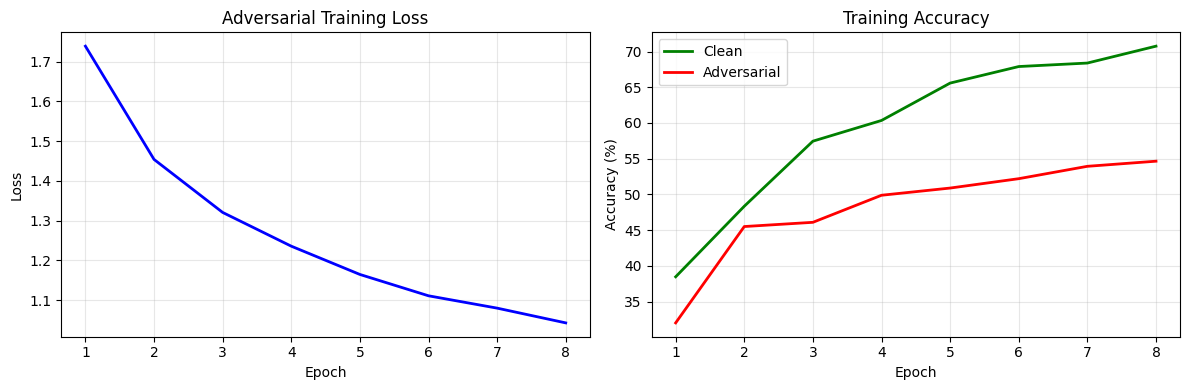

Adversarial training complete!

Testing robust model performance:

📊 Test Results:
Overall Accuracy: 73.55%

Per-class Accuracy:
     plane: 76.8%
       car: 90.3%
      bird: 42.2%
       cat: 47.7%
      deer: 73.3%
       dog: 65.1%
      frog: 86.0%
     horse: 81.4%
      ship: 90.4%
     truck: 82.3%


In [15]:
def adversarial_training(model, trainloader, epochs=8, epsilon=0.03):
    """
    Adversarial Training - train on mix of clean and adversarial examples
    """
    print(f"\nAdversarial Training (ε = {epsilon})...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    adv_accuracies = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_clean = 0
        correct_adv = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f'Robust Training Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 50% clean, 50% adversarial examples
            if torch.rand(1) < 0.5:
                # Use adversarial examples
                adv_inputs = fgsm_attack(model, inputs.clone(), labels, epsilon)
                train_inputs = adv_inputs
                is_adv = True
            else:
                # Use clean examples
                train_inputs = inputs
                is_adv = False
            
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            
            if is_adv:
                correct_adv += predicted.eq(labels).sum().item()
            else:
                correct_clean += predicted.eq(labels).sum().item()
            
            # Show both clean and adversarial accuracy during training
            clean_acc = 100. * correct_clean / (total/2) if total > 0 else 0
            adv_acc = 100. * correct_adv / (total/2) if total > 0 else 0
            
            pbar.set_postfix({
                'Loss': f'{running_loss/len(trainloader):.3f}',
                'Clean': f'{clean_acc:.1f}%',
                'Adv': f'{adv_acc:.1f}%'
            })
        
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        train_accuracies.append(clean_acc)
        adv_accuracies.append(adv_acc)
    
    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(range(1, epochs+1), train_losses, 'b-', linewidth=2)
    ax1.set_title('Adversarial Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(range(1, epochs+1), train_accuracies, 'g-', linewidth=2, label='Clean')
    ax2.plot(range(1, epochs+1), adv_accuracies, 'r-', linewidth=2, label='Adversarial')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Adversarial training complete!")
    return model

# Train robust model
robust_model = SimpleNet()
robust_model = adversarial_training(robust_model, trainloader, epochs=8)

print("\nTesting robust model performance:")
robust_clean_acc = test_model(robust_model, testloader)


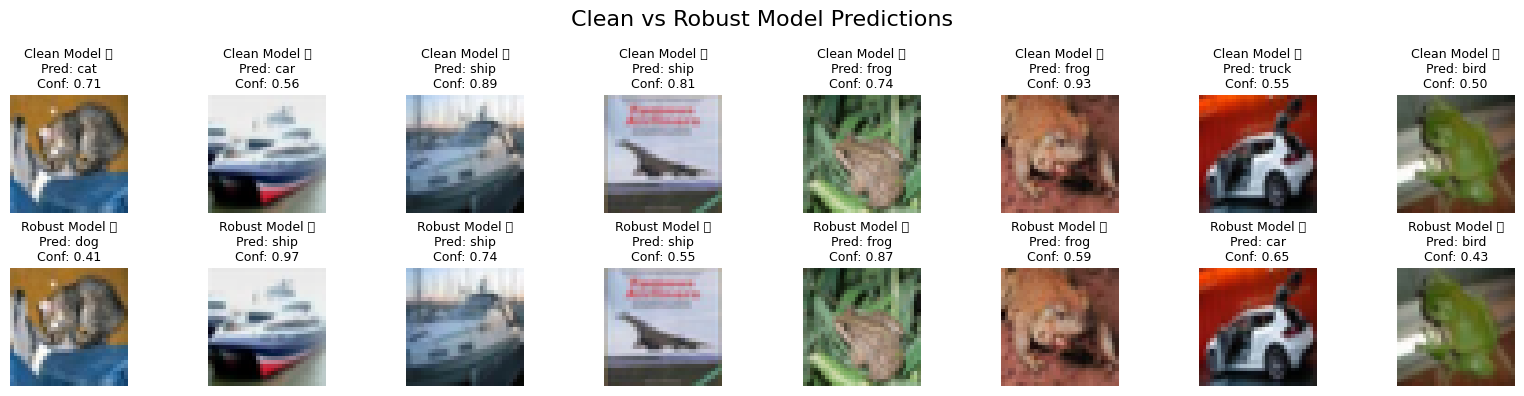

In [16]:
def compare_model_predictions(clean_model, robust_model, images, labels, num_examples=8):
    """Compare predictions from clean and robust models"""
    
    clean_model.eval()
    robust_model.eval()
    
    with torch.no_grad():
        clean_outputs = clean_model(images[:num_examples])
        robust_outputs = robust_model(images[:num_examples])
        
        clean_preds = torch.argmax(clean_outputs, dim=1)
        robust_preds = torch.argmax(robust_outputs, dim=1)
        
        clean_probs = F.softmax(clean_outputs, dim=1)
        robust_probs = F.softmax(robust_outputs, dim=1)
        
        clean_conf = torch.max(clean_probs, dim=1)[0]
        robust_conf = torch.max(robust_probs, dim=1)[0]
    
    images_viz = denormalize_images(images[:num_examples])
    
    fig, axes = plt.subplots(2, num_examples, figsize=(16, 4))
    fig.suptitle('Clean vs Robust Model Predictions', fontsize=16)
    
    for i in range(num_examples):
        # Clean model predictions
        axes[0, i].imshow(images_viz[i].permute(1, 2, 0).clamp(0, 1))
        clean_correct = '✅' if clean_preds[i] == labels[i] else '❌'
        axes[0, i].set_title(f'Clean Model {clean_correct}\nPred: {classes[clean_preds[i]]}\nConf: {clean_conf[i]:.2f}', 
                           fontsize=9)
        axes[0, i].axis('off')
        
        # Robust model predictions
        axes[1, i].imshow(images_viz[i].permute(1, 2, 0).clamp(0, 1))
        robust_correct = '✅' if robust_preds[i] == labels[i] else '❌'
        axes[1, i].set_title(f'Robust Model {robust_correct}\nPred: {classes[robust_preds[i]]}\nConf: {robust_conf[i]:.2f}', 
                           fontsize=9)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

compare_model_predictions(clean_model, robust_model, sample_images, sample_labels)



Model Robustness Comparison (FGSM_ATTACK, ε = 0.03)


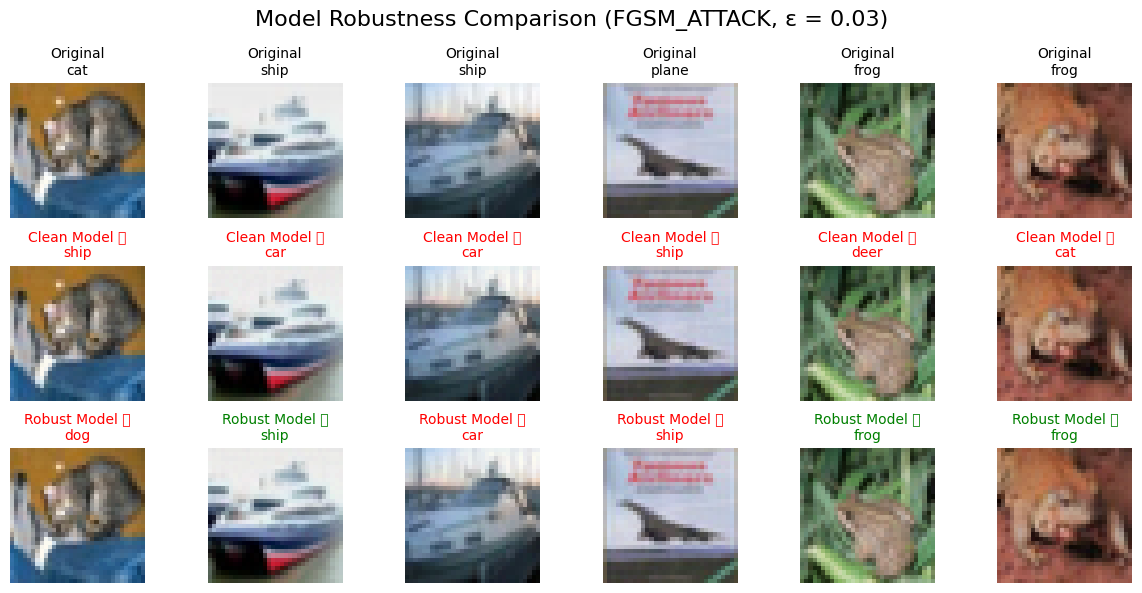

Clean Model Attack Success:  6/6 (100.0%)
Robust Model Attack Success: 3/6 (50.0%)
🛡️ Defense Improvement: 50.0 percentage points

Model Robustness Comparison (PGD_ATTACK, ε = 0.03)


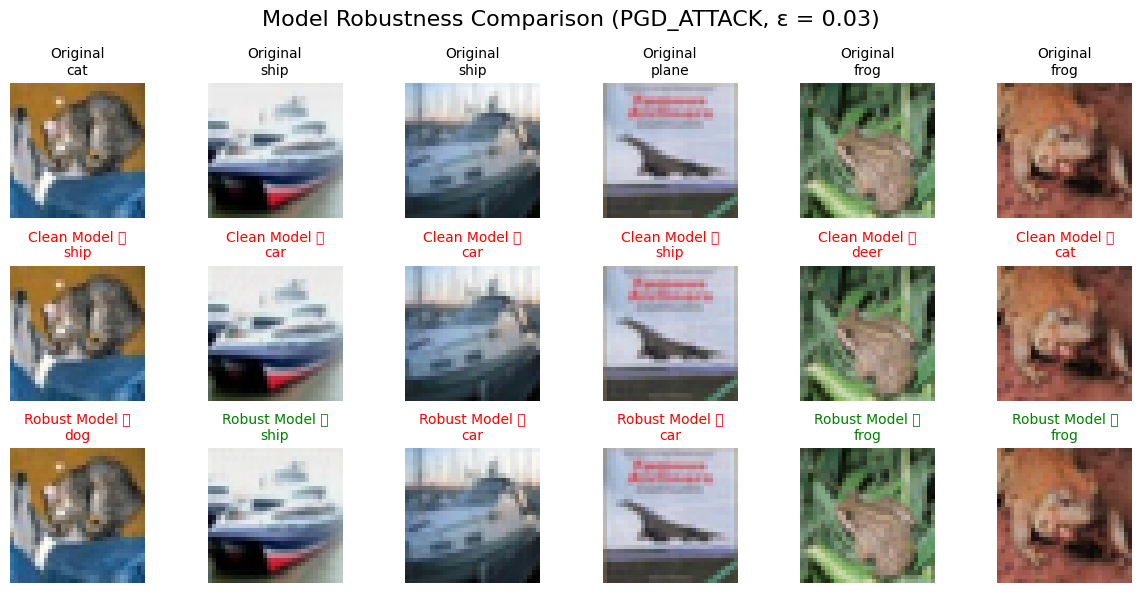

Clean Model Attack Success:  6/6 (100.0%)
Robust Model Attack Success: 3/6 (50.0%)
🛡️ Defense Improvement: 50.0 percentage points


In [17]:
def compare_model_robustness(clean_model, robust_model, images, labels, attack_fn, epsilon, num_examples=6):
    """Compare how clean and robust models handle attacks"""
    
    print(f"\nModel Robustness Comparison ({attack_fn.__name__.upper()}, ε = {epsilon})")
    
    # Generate adversarial examples for both models
    clean_adv = attack_fn(clean_model, images, labels, epsilon)
    robust_adv = attack_fn(robust_model, images, labels, epsilon)
    
    # Get predictions
    clean_model.eval()
    robust_model.eval()
    
    with torch.no_grad():
        # Clean images
        clean_clean_outputs = clean_model(images[:num_examples])
        robust_clean_outputs = robust_model(images[:num_examples])
        
        # Adversarial images
        clean_adv_outputs = clean_model(clean_adv[:num_examples])
        robust_adv_outputs = robust_model(robust_adv[:num_examples])
        
        clean_clean_preds = torch.argmax(clean_clean_outputs, dim=1)
        robust_clean_preds = torch.argmax(robust_clean_outputs, dim=1)
        clean_adv_preds = torch.argmax(clean_adv_outputs, dim=1)
        robust_adv_preds = torch.argmax(robust_adv_outputs, dim=1)
    
    # Visualize
    clean_viz = denormalize_images(images[:num_examples])
    clean_adv_viz = denormalize_images(clean_adv[:num_examples])
    robust_adv_viz = denormalize_images(robust_adv[:num_examples])
    
    fig, axes = plt.subplots(3, num_examples, figsize=(2*num_examples, 6))
    fig.suptitle(f'Model Robustness Comparison ({attack_fn.__name__.upper()}, ε = {epsilon})', fontsize=16)
    
    clean_success = 0
    robust_success = 0
    
    for i in range(num_examples):
        # Original images
        axes[0, i].imshow(clean_viz[i].permute(1, 2, 0).clamp(0, 1))
        axes[0, i].set_title(f'Original\n{classes[labels[i]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Clean model under attack
        axes[1, i].imshow(clean_adv_viz[i].permute(1, 2, 0).clamp(0, 1))
        clean_attack_success = clean_adv_preds[i] != labels[i]
        if clean_attack_success:
            clean_success += 1
        symbol = '🎯' if clean_attack_success else '✅'
        color = 'red' if clean_attack_success else 'green'
        axes[1, i].set_title(f'Clean Model {symbol}\n{classes[clean_adv_preds[i]]}', 
                           fontsize=10, color=color)
        axes[1, i].axis('off')
        
        # Robust model under attack
        axes[2, i].imshow(robust_adv_viz[i].permute(1, 2, 0).clamp(0, 1))
        robust_attack_success = robust_adv_preds[i] != labels[i]
        if robust_attack_success:
            robust_success += 1
        symbol = '🎯' if robust_attack_success else '✅'
        color = 'red' if robust_attack_success else 'green'
        axes[2, i].set_title(f'Robust Model {symbol}\n{classes[robust_adv_preds[i]]}', 
                           fontsize=10, color=color)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    clean_success_rate = (clean_success / num_examples) * 100
    robust_success_rate = (robust_success / num_examples) * 100
    
    print(f"Clean Model Attack Success:  {clean_success}/{num_examples} ({clean_success_rate:.1f}%)")
    print(f"Robust Model Attack Success: {robust_success}/{num_examples} ({robust_success_rate:.1f}%)")
    print(f"🛡️ Defense Improvement: {clean_success_rate - robust_success_rate:.1f} percentage points")

# Test both models against FGSM
compare_model_robustness(clean_model, robust_model, sample_images, sample_labels, fgsm_attack, 0.03)

# Test both models against PGD
compare_model_robustness(clean_model, robust_model, sample_images, sample_labels, pgd_attack, 0.03)


Comparing model robustness across epsilon values...
Testing ε = 0.010...
  Clean Model: 66.0%  |  Robust Model: 68.3%
Testing ε = 0.020...
  Clean Model: 52.7%  |  Robust Model: 61.7%
Testing ε = 0.030...
  Clean Model: 41.3%  |  Robust Model: 55.7%
Testing ε = 0.050...
  Clean Model: 27.7%  |  Robust Model: 45.0%
Testing ε = 0.070...
  Clean Model: 18.7%  |  Robust Model: 35.3%


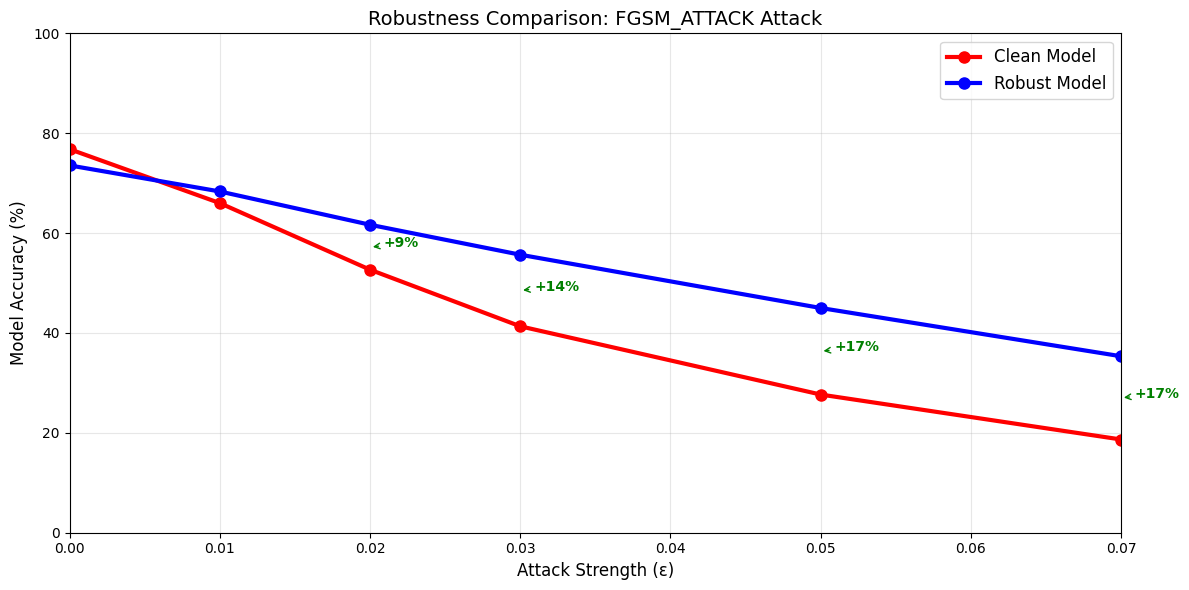

In [18]:
def plot_model_comparison(clean_model, robust_model, testloader, attack_fn, epsilons, max_batches=5):
    """Compare robustness of both models across epsilon values"""
    
    clean_accs = []
    robust_accs = []
    
    print("Comparing model robustness across epsilon values...")
    for eps in epsilons:
        print(f"Testing ε = {eps:.3f}...")
        
        # Test clean model
        clean_correct = 0
        total = 0
        for batch_idx, (inputs, labels) in enumerate(testloader):
            if batch_idx >= max_batches:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            adv_inputs = attack_fn(clean_model, inputs, labels, eps)
            with torch.no_grad():
                outputs = clean_model(adv_inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                clean_correct += (predicted == labels).sum().item()
        clean_acc = 100 * clean_correct / total
        clean_accs.append(clean_acc)
        
        # Test robust model
        robust_correct = 0
        total = 0
        for batch_idx, (inputs, labels) in enumerate(testloader):
            if batch_idx >= max_batches:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            adv_inputs = attack_fn(robust_model, inputs, labels, eps)
            with torch.no_grad():
                outputs = robust_model(adv_inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                robust_correct += (predicted == labels).sum().item()
        robust_acc = 100 * robust_correct / total
        robust_accs.append(robust_acc)
        
        print(f"  Clean Model: {clean_acc:.1f}%  |  Robust Model: {robust_acc:.1f}%")
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    x_vals = [0] + epsilons
    clean_vals = [clean_accuracy] + clean_accs
    robust_vals = [robust_clean_acc] + robust_accs
    
    plt.plot(x_vals, clean_vals, 'ro-', linewidth=3, markersize=8, label='Clean Model')
    plt.plot(x_vals, robust_vals, 'bo-', linewidth=3, markersize=8, label='Robust Model')
    
    plt.xlabel('Attack Strength (ε)', fontsize=12)
    plt.ylabel('Model Accuracy (%)', fontsize=12)
    plt.title(f'Robustness Comparison: {attack_fn.__name__.upper()} Attack', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max(epsilons))
    plt.ylim(0, 100)
    
    # Add annotations showing the improvement
    for i, eps in enumerate(x_vals):
        improvement = robust_vals[i] - clean_vals[i]
        if improvement > 5:  # Only annotate significant improvements
            plt.annotate(f'+{improvement:.0f}%', 
                        xy=(eps, (clean_vals[i] + robust_vals[i])/2),
                        xytext=(10, 0), textcoords='offset points',
                        fontsize=10, color='green', weight='bold',
                        arrowprops=dict(arrowstyle='->', color='green'))
    
    plt.tight_layout()
    plt.show()
    
    return clean_accs, robust_accs

eps_comparison = [0.01, 0.02, 0.03, 0.05, 0.07]
clean_robustness_comp, robust_robustness_comp = plot_model_comparison(
    clean_model, robust_model, testloader, fgsm_attack, eps_comparison, max_batches=3
)

In [19]:
def analyze_tradeoffs(clean_model, robust_model, testloader, attack_fn, epsilon):
    """Analyze the trade-offs between clean and robust accuracy"""
    
    print(f"\nPerformance Analysis:")
    print(f"{'Metric':<25} {'Clean Model':<15} {'Robust Model':<15} {'Difference':<12}")
    print("-" * 70)
    
    # Clean accuracy
    diff_clean = robust_clean_acc - clean_accuracy
    print(f"{'Clean Accuracy':<25} {clean_accuracy:<14.1f}% {robust_clean_acc:<14.1f}% {diff_clean:<+11.1f}%")
    
    # Adversarial accuracy
    def test_adv_accuracy(model, testloader, attack_fn, epsilon, max_batches=5):
        correct = 0
        total = 0
        for batch_idx, (inputs, labels) in enumerate(testloader):
            if batch_idx >= max_batches:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            adv_inputs = attack_fn(model, inputs, labels, epsilon)
            with torch.no_grad():
                outputs = model(adv_inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total
    
    clean_adv_acc = test_adv_accuracy(clean_model, testloader, attack_fn, epsilon)
    robust_adv_acc = test_adv_accuracy(robust_model, testloader, attack_fn, epsilon)
    diff_adv = robust_adv_acc - clean_adv_acc
    
    print(f"{'Adversarial Accuracy':<25} {clean_adv_acc:<14.1f}% {robust_adv_acc:<14.1f}% {diff_adv:<+11.1f}%")
    
    # Attack success rates
    clean_attack_success = 100 - clean_adv_acc
    robust_attack_success = 100 - robust_adv_acc
    diff_attack = clean_attack_success - robust_attack_success
    
    print(f"{'Attack Success Rate':<25} {clean_attack_success:<14.1f}% {robust_attack_success:<14.1f}% {diff_attack:<+11.1f}%")
    
    # Summary
    print(f"\nKey Insights:")
    if diff_clean < 0:
        print(f"   • Robust model sacrifices {abs(diff_clean):.1f}% clean accuracy for robustness")
    else:
        print(f"   • Robust model maintains clean accuracy (+{diff_clean:.1f}%)")
    
    print(f"   • Robust model reduces attack success by {diff_attack:.1f} percentage points")
    print(f"   • Trade-off ratio: {abs(diff_clean/diff_attack):.2f}% clean accuracy per 1% robustness gain")
    
    return {
        'clean_acc_diff': diff_clean,
        'adv_acc_diff': diff_adv,
        'attack_success_reduction': diff_attack
    }

tradeoffs = analyze_tradeoffs(clean_model, robust_model, testloader, fgsm_attack, 0.03)



📊 Performance Analysis:
Metric                    Clean Model     Robust Model    Difference  
----------------------------------------------------------------------
Clean Accuracy            76.8          % 73.5          % -3.2       %
Adversarial Accuracy      43.0          % 55.8          % +12.8      %
Attack Success Rate       57.0          % 44.2          % +12.8      %

💡 Key Insights:
   • Robust model sacrifices 3.2% clean accuracy for robustness
   • Robust model reduces attack success by 12.8 percentage points
   • Trade-off ratio: 0.25% clean accuracy per 1% robustness gain



🤔 Model Agreement Analysis:
Models agree on 62.5% of examples
Examples where models disagree:


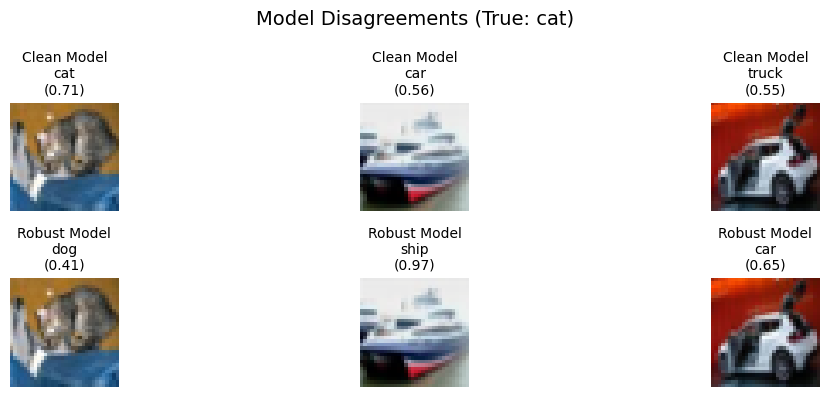

In [20]:
def visualize_model_differences(clean_model, robust_model, images, labels, num_examples=8):
    """Visualize differences in how models process the same images"""
    
    clean_model.eval()
    robust_model.eval()
    
    with torch.no_grad():
        clean_outputs = clean_model(images[:num_examples])
        robust_outputs = robust_model(images[:num_examples])
        
        clean_probs = F.softmax(clean_outputs, dim=1)
        robust_probs = F.softmax(robust_outputs, dim=1)
        
        clean_preds = torch.argmax(clean_outputs, dim=1)
        robust_preds = torch.argmax(robust_outputs, dim=1)
    
    # Find examples where models disagree
    disagreements = clean_preds != robust_preds
    agreement_rate = (1 - disagreements.float().mean()) * 100
    
    print(f"\n🤔 Model Agreement Analysis:")
    print(f"Models agree on {agreement_rate:.1f}% of examples")
    
    if disagreements.sum() > 0:
        print("Examples where models disagree:")
        disagree_indices = torch.where(disagreements)[0]
        
        fig, axes = plt.subplots(2, min(4, len(disagree_indices)), figsize=(12, 4))
        if len(disagree_indices) == 1:
            axes = axes.reshape(2, 1)
        
        images_viz = denormalize_images(images[:num_examples])
        
        for i, idx in enumerate(disagree_indices[:4]):
            if i >= 4:
                break
                
            # Clean model view
            axes[0, i].imshow(images_viz[idx].permute(1, 2, 0).clamp(0, 1))
            clean_conf = clean_probs[idx, clean_preds[idx]].item()
            axes[0, i].set_title(f'Clean Model\n{classes[clean_preds[idx]]}\n({clean_conf:.2f})', fontsize=10)
            axes[0, i].axis('off')
            
            # Robust model view
            axes[1, i].imshow(images_viz[idx].permute(1, 2, 0).clamp(0, 1))
            robust_conf = robust_probs[idx, robust_preds[idx]].item()
            axes[1, i].set_title(f'Robust Model\n{classes[robust_preds[idx]]}\n({robust_conf:.2f})', fontsize=10)
            axes[1, i].axis('off')
        
        plt.suptitle(f'Model Disagreements (True: {classes[labels[disagree_indices[0]]]})', fontsize=14)
        plt.tight_layout()
        plt.show()

visualize_model_differences(clean_model, robust_model, sample_images, sample_labels)


### Summary

There are obvious findings in this toy example. 
First, we have a simple CNN with 3 convolutional layers and 2 fully-connected layers, trained on the CIFAR10 dataset of 10 classes of 32 x 32 pixel images.
Secondly, we implemented the FGSM and PGD attacks using epsilons from 0.005 -> 0.1. These examples were met with a significant drop in accuracy in our model's classification abilities of around 30 percent.
Thirdly, our robust model trained on both clean and adversarial examples had a minor drop of 3 percent in classification accuracy on clean samples, and proved more resistant to misclassifying adversarial examples, with accuracy falling around 18 percent.

### Next steps

We suggest exploring some of these research directions:

* Try other defences, such as randomized smoothing or defensive distillation. Try stronger attacks, such as DeepFool, AutoAttack or C&W.
* Looking at transferability across models can be very interesting, do the adversarial examples prove similarly effective?
* Experiment with pretrained (and more robust) models such as ResNet18 or MobileNet. 

